In [1]:
import os
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import random
import glob
import numpy as np
from scipy.ndimage import rotate
import csv
import SimpleITK as sitk
#from lungtumormask import mask as tumormask
#from lungmask import mask as lungmask_fun

from monai.utils import first, set_determinism
from monai.transforms import (
    RandFlipd,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    KeepLargestConnectedComponent,
    RandCropByPosNegLabeld,
    SaveImaged,
    CenterSpatialCropd,
    SpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    AsDiscrete,
    SpatialCrop,
    RandSpatialCropd,
    SpatialPadd,
    EnsureTyped,
    EnsureType,
    Invertd,
    DivisiblePadd,
    MapTransform,
    HistogramNormalized,
    ToTensord,
    Transpose,
    ToTensor,
)
from monai.optimizers import LearningRateFinder
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet,VNet,SwinUNETR,UNETR,DynUNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric,SurfaceDiceMetric,SurfaceDistanceMetric,HausdorffDistanceMetric
from monai.losses import DiceLoss,DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch,pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)


if True:
    %matplotlib inline

device: cuda


In [3]:
#peregrine
#root_path = '/data/p308104/NBIA_Data/NIFTI_NBIA/imagesTr/'
#root_path = '/data/p308104/Nifti_Imgs_V0/' #UMCG data on peregrine
#root_path = '/data/p308104/MultipleBP/'
#local
#root_path = '/home/umcg/Desktop/NBIA/NBIA_Nifti_v0/'
#root_path = '/home/umcg/Desktop/Dicom_UMCG/MultipleBP/' 
root_path = '/home/umcg/OneDrive/MultipleBreathingP/'
#root_path = '/home/umcg/Desktop/AutomaticITV_code/MultipleBreathingP-OneDriveCopy/MultipleBreathingP/'


all_patientdir = []
all_patientdir = os.listdir(root_path)
all_patientdir.sort()
print(len(all_patientdir))


214


In [12]:
CT_fpaths = []
lbl_fpaths= []
lung_fpaths = []
for patient_path in all_patientdir:
    ct_miss = True
    gtv_miss = True
    lung_miss = True
    f_pxOk = 0
    for root, dirs, files in os.walk(root_path+patient_path, topdown=False):   
        for f in files:
            if "50%_ct.nii.gz" in f.lower() and ct_miss:
                CT_fpaths.append(os.path.join(root_path,patient_path,f))
                ct_miss = False
                f_pxOk +=1
            if "rtstruct_gtv.nii.gz" in f.lower():
                lbl_fpaths.append(os.path.join(root_path,patient_path,f))
                gtv_miss =False
                f_pxOk +=1
            if '50%_lungmask.nii.gz' in f.lower():
                lung_fpaths.append(os.path.join(root_path,patient_path,f))
                lung_miss = False
                f_pxOk +=1
        if ct_miss:
            for f in files:
                if "ex_ct.nii.gz" in f.lower() and ct_miss:
                    CT_fpaths.append(os.path.join(root_path,patient_path,f))
                    ct_miss = False
                    f_pxOk +=1
                if 'ex_lungmask.nii.gz' in f.lower() and lung_miss:
                    lung_fpaths.append(os.path.join(root_path,patient_path,f))
                    lung_miss = False
                    f_pxOk +=1
        if gtv_miss and not(ct_miss): 
            CT_fpaths.pop()
            f_pxOk -=1
        if gtv_miss and not(lung_miss): 
            lung_fpaths.pop()
            f_pxOk -=1
        if not(gtv_miss) and (ct_miss): 
            print(root)
            for f in files:
                if "mar_ct.nii.gz" in f.lower() and ct_miss:
                    CT_fpaths.append(os.path.join(root_path,patient_path,f))
                    ct_miss = False
                    f_pxOk +=1
                if "in_ct.nii.gz" in f.lower() and ct_miss:
                    CT_fpaths.append(os.path.join(root_path,patient_path,f))
                    ct_miss = False
                    f_pxOk +=1
                if 'mar_lungmask.nii.gz' in f.lower() and lung_miss:
                    lung_fpaths.append(os.path.join(root_path,patient_path,f))
                    lung_miss = False
                    f_pxOk +=1
                if 'in_lungmask.nii.gz' in f.lower() and lung_miss:
                    lung_fpaths.append(os.path.join(root_path,patient_path,f))
                    lung_miss = False
                    f_pxOk +=1
            
print(len(CT_fpaths),len(lbl_fpaths),len(lung_fpaths))
CT_fpaths.sort()
lbl_fpaths.sort()
lung_fpaths.sort()

print(CT_fpaths[44])
print(lbl_fpaths[44])
print(lung_fpaths[44])

/home/umcg/OneDrive/MultipleBreathingP/0170341
/home/umcg/OneDrive/MultipleBreathingP/1642692
190 190 190
/home/umcg/OneDrive/MultipleBreathingP/1372853/1372853_50%_ct.nii.gz
/home/umcg/OneDrive/MultipleBreathingP/1372853/1372853_rtstruct_GTV.nii.gz
/home/umcg/OneDrive/MultipleBreathingP/1372853/1372853_50%_LungMask.nii.gz


In [5]:
# Save csv file of patients ok and px not ok 
if False:
    print('List Ok: ',len(list_PxOk),'List NOT Ok',len(list_PxNOTOk))
    file = open('ListPatientsStatus.csv', 'w')
    writer = csv.writer(file)
    writer.writerow(['Patients Ok'])
    writer.writerow(list_PxOk)
    writer.writerow(['Patients NOT Ok'])
    writer.writerow(list_PxNOTOk)
    file.close()

In [ ]:
#Predicts both tumor and lung mask
Predict = False
w = '50%'
if Predict:
    gtv = lbl_fpaths[0]
    gtv = nib.load(gtv)

    for ct in CT_fpaths:
        empty_header = nib.Nifti1Header()
        predicted_path = root_path+ct+'_'+w+'_predictedTS.nii.gz'
        lung_path = ct[:-10]+'_LungMask.nii.gz'
        #Get Tumor mask
        #tumormask.mask(ct, predicted_path)
        #Get Lung mask and save it
        input_image = sitk.ReadImage(ct, imageIO='NiftiImageIO')
        lungmask = lungmask_fun.apply(input_image)  # default model is U-net(R231)
        lungmask_ni = nib.Nifti1Image(lungmask, gtv.affine,empty_header)
        nib.save(lungmask_ni,lung_path)

In [ ]:
#Check max min tumor values
if False :
    minmin = 10
    maxmax = 0
    for i in range(len(data_dicts)):
        img = nib.load(data_dicts[i]["lung"])
        data_img = img.get_fdata()
        data_img = np.transpose(data_img, (1,2,0))# fix misshape 
        for j in range(data_img.shape[2]):
            if np.sum(data_img[:,:,j])>0:
                plt.imshow(data_img[:,:,j])
                plt.show()
        break
        if np.min(data_img) < minmin:
          minmin = np.min(data_img)
        if np.max(data_img) > maxmax:
          maxmax = np.max(data_img)

    print("minmin: ",minmin,"maxmax: ", maxmax)


In [13]:
#Create data dictionat
data_dicts = [
    {"image": image_name,"lung":lung_name,"label": label_name}
    for image_name,lung_name,label_name in zip(CT_fpaths,lung_fpaths,lbl_fpaths)
]
train_files, val_files = data_dicts[:-45], data_dicts[-45:]
print('train val len:',len(train_files),'-',len(val_files))

minmin_CT = -1024 #NBIA
maxmax_CT = 3071 #NBIA

train val len: 145 - 45


In [14]:
#class to transpose lung mask
class Create_sequences(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        
        print(f"keys to transpose: {self.keys}")

         
    def __call__(self, dictionary):
        dictionary = dict(dictionary)
        for key in self.keys:
            data = dictionary[key]
            if key == 'lung':
                data = np.transpose(data, (0,2,3,1))
                data = rotate(data,270,axes=(1,2),reshape=False)
                data = np.flip(data,1)
                data[data==2] = int(1)
                data[data!=1] = int(0)
            dictionary[key] = data
            
        return dictionary        

In [15]:
#Create Compose functions for preprocessing of train and validation
set_determinism(seed=0)
image_keys = ["image","lung","label"]
p = .5 #Data aug transform probability
size = 96
image_size = (size,size,size)
train_transforms = Compose(
    [
        LoadImaged(keys=image_keys),
        EnsureChannelFirstd(keys=image_keys),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        #Spacingd(keys=["image","label"], pixdim=(1,1,1),mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        Create_sequences(keys=image_keys),
        CropForegroundd(keys=image_keys, source_key="lung",k_divisible = size),
        RandCropByPosNegLabeld(
            keys=image_keys,label_key='label',spatial_size=image_size,pos=1,neg=1,num_samples=2,
            image_key='image',image_threshold=0,),
        #RandFlipd(keys=image_keys,spatial_axis=[0],prob=p / 3,),
        #RandFlipd(keys=image_keys,spatial_axis=[1],prob=p / 3,),
        #RandFlipd(keys=image_keys,spatial_axis=[2],prob=p / 3,),
        ToTensord(keys=image_keys),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=image_keys),
        EnsureChannelFirstd(keys=image_keys),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        #Spacingd(keys=["image","label"], pixdim=(1,1,1),mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        Create_sequences(keys=image_keys),
        CropForegroundd(keys=image_keys, source_key="lung",k_divisible = size),
        ToTensord(keys=image_keys),
    ]
)


keys to transpose: ('image', 'lung', 'label')
keys to transpose: ('image', 'lung', 'label')


px info:1,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)
px info:2,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)


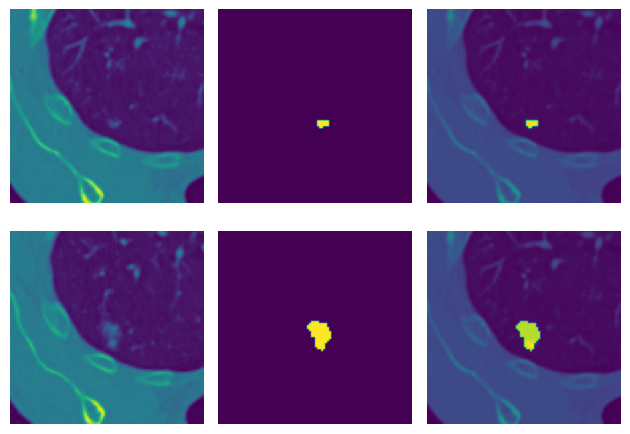

px info:3,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)


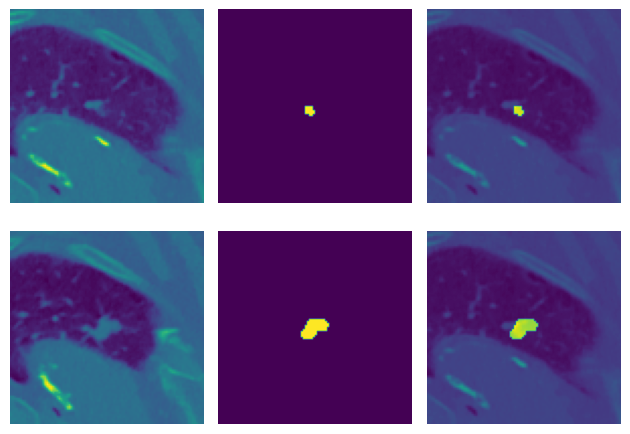

px info:4,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)
px info:5,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)
px info:6,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)


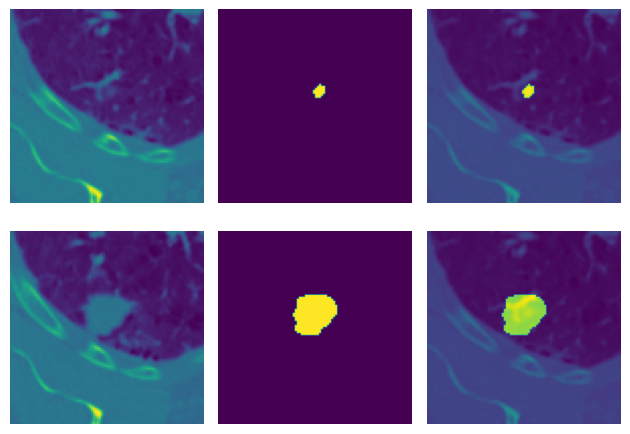

px info:7,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)


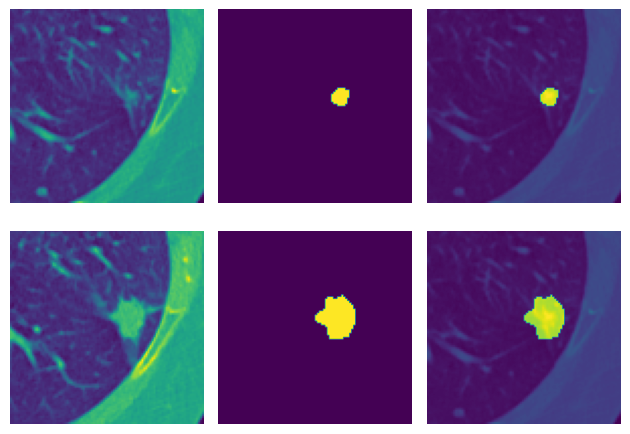

px info:8,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)
px info:9,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)


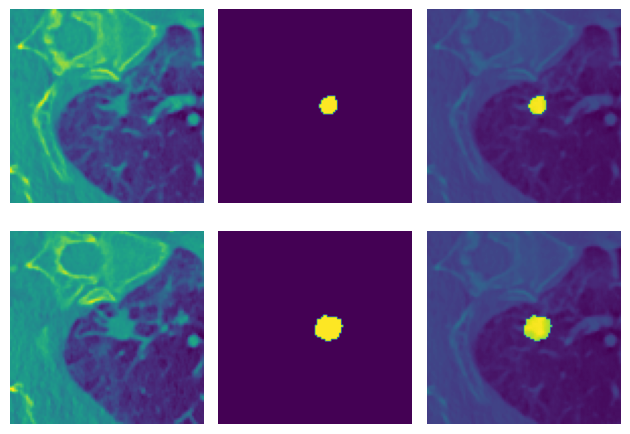

px info:10,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)


In [16]:
#Check the images after the preprocessing
if True:
    check_ds =Dataset(data=train_files, transform=train_transforms)
    check_loader = DataLoader(check_ds, batch_size=1,num_workers=0)
    if True:
        count = 1
        for batch_data in check_loader:
            #batch_data = first(check_loader)
            image,lung, label = (batch_data["image"][0][0],batch_data["lung"][0][0],batch_data["label"][0][0])
            print(f"px info:{count },image shape: {image.shape},lung shape: {lung.shape}, label shape: {label.shape}")
            count+=1
            for i in range(label.shape[2]):
                if torch.sum(label[:,:,i])>0:
                    plt.subplot(2,3,1),plt.imshow(image[:,:,i]),plt.axis('off')
                    plt.subplot(2,3,2),plt.imshow(label[:,:,i]),plt.axis('off')
                    plt.subplot(2,3,3),plt.imshow(label[:,:,i]+image[:,:,i]),plt.axis('off')
                    plt.subplot(2,3,4),plt.imshow(image[:,:,i+2]),plt.axis('off')
                    plt.subplot(2,3,5),plt.imshow(label[:,:,i+2]),plt.axis('off')
                    plt.subplot(2,3,6),plt.imshow(label[:,:,i+2]+image[:,:,i]),plt.axis('off')
                    plt.tight_layout(),plt.show()
                    break
            if count>10:
                break

In [17]:
#Get the dataset ready for the model
if True:
    train_ds = Dataset(data=train_files, transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

    val_ds = Dataset(data=val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)#,collate_fn=pad_list_data_collate)

In [18]:
#Create the model
spatial_dims = 3
max_epochs = 100
in_channels = 1
out_channels=2 #including background

model = SwinUNETR(
    image_size, 
    in_channels, out_channels, 
    use_checkpoint=True, 
    feature_size=24,
    #spatial_dims=spatial_dims
).to(device)


#metrics
dice_metric = DiceMetric(include_background=False, reduction="mean")
surfDice_metric_1Class = SurfaceDiceMetric([10],include_background=False)
hausdorff_metric = HausdorffDistanceMetric(include_background=True, reduction="mean")

In [19]:
# Load pretrained model
#pretrained_path = '/home/umcg/Desktop/AutomaticITV_code/weights/best_m_MONAI_V3_NBIAWeightsretrainedWithUMCGdata.pth'
weights_name = 'best_m_MONAI_V3_UMCGWeightsretrainedWithUMCGdata_X2RetrainedwithAITVdata.pth'
pretrained_path = '/data/p308104/MultipleBP/'+weights_name
if pretrained_path is not(None):
    model.load_state_dict(torch.load(pretrained_path, map_location=torch.device(device)))

    #weight = torch.load(pretrained_path, map_location=torch.device(device))
    #model.load_from(weights=weight)
    print('Using pretrained weights!')

FileNotFoundError: [Errno 2] No such file or directory: '/data/p308104/MultipleBP/best_m_MONAI_V3_UMCGWeightsretrainedWithUMCGdata_X2RetrainedwithAITVdata.pth'

In [20]:
#params
#loss_function = DiceLoss(include_background=False,to_onehot_y=True, sigmoid=True)
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)

#Previous optimizer
#optimizer = torch.optim.Adam(model.parameters(), 1e-4)
#New Optimizer LR finder
lower_lr, upper_lr = 1e-5, 1e-0
optimizer = torch.optim.Adam(model.parameters(), lower_lr)
lr_finder = LearningRateFinder(model, optimizer, loss_function, device=device)
lr_finder.range_test(train_loader, val_loader, end_lr=upper_lr, num_iter=20)
steepest_lr, _ = lr_finder.get_steepest_gradient()
ax = plt.subplots(1, 1, figsize=(15, 15), facecolor="white")[1]
_ = lr_finder.plot(ax=ax)

Computing optimal learning rate:   0%|                   | 0/20 [00:17<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 324.00 MiB (GPU 0; 7.93 GiB total capacity; 6.08 GiB already allocated; 245.31 MiB free; 6.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
post_transforms = Compose(
    [
        EnsureType(),
        AsDiscrete(argmax=True,to_onehot=out_channels, threshold=.5),
        FillHoles(applied_labels=1, connectivity=0),
        RemoveSmallObjects(min_size=5, connectivity=3, independent_channels=True),
        #KeepLargestConnectedComponent(applied_labels=None,is_onehot=True,connectivity=3, num_components=3),
   ]
)

post_pred = Compose([EnsureType(), AsDiscrete(argmax=True,threshold=0.5)])
post_label = Compose([EnsureType(), AsDiscrete(threshold=0.5)],)

#print(postImg_monai[0].shape)

#plt.subplot(1,2,1),plt.imshow(val_outputs[0,1,:,:,104].cpu())
#plt.subplot(1,2,2),plt.imshow(postImg_monai[0][1,:,:,104].cpu())
#plt.show()

In [ ]:
#compute metric for current iteration
#Batch x Channel x Height x Width - [B,C,H,W] - 1, 384, 288, 192
#Channel is number of classes
def surfDiceFun(val_labels,postImg_monai):
    ylabe_BCHW_neg = val_labels[0].cpu().numpy()
    ylabe_BCHW_neg = ylabe_BCHW_neg*-1+1
    ylabe_BCHW_pos = val_labels[0].cpu().numpy()
    ylabe_BCHW = np.concatenate((ylabe_BCHW_neg, ylabe_BCHW_pos),0)
    transpose_monai = Compose([Transpose([3, 0, 1, 2])])
    ylabe_BCHW = transpose_monai(ylabe_BCHW)
    ypred_BCHW = postImg_monai[0].permute(3, 0, 1, 2)

    list_surf=[]
    for i in range(ypred_BCHW.shape[0]-4):
        surfDice_metric(y_pred=ypred_BCHW[i:i+2,:,:,:], y=ylabe_BCHW[i:i+2,:,:,:])
        #print('SurfFice monai    :',surfDice_metric.aggregate().item())
        list_surf.append(surfDice_metric.aggregate().item())
        surfDice_metric.reset()
    return np.mean(list_surf)

def surfDiceFun_1Class(val_labels,postImg_monai):
    ylabe_BCHW_neg = val_labels[0].cpu().numpy()
    ylabe_BCHW_neg = ylabe_BCHW_neg*-1+1
    ylabe_BCHW_pos = val_labels[0].cpu().numpy()
    ylabe_BCHW = np.concatenate((ylabe_BCHW_neg, ylabe_BCHW_pos),0)
    transpose_monai = Compose([Transpose([3, 0, 1, 2])])
    ylabe_BCHW = transpose_monai(ylabe_BCHW)
    ypred_BCHW = postImg_monai[0].permute(3, 0, 1, 2)
    
    #print(ypred_BCHW.shape,ylabe_BCHW.shape)
    list_surf=[]
    for i in range(ypred_BCHW.shape[0]-4):
        if  np.sum(ylabe_BCHW[i:i+2,1,:,:])>0:# or np.sum(ypred_BCHW[i:i+2,0,:,:])>0:
            surfDice_metric_1Class(y_pred=ypred_BCHW[i:i+2,:,:,:], y=ylabe_BCHW[i:i+2,0:,:,:])
            list_surf.append(surfDice_metric_1Class.aggregate().item())
            #print(list_surf[-1])
            surfDice_metric_1Class.reset()
    return np.mean(list_surf)
#hausdorff_metric(y_pred=postImg_monai, y=val_labels)
#print('hausdorff monai    :',hausdorff_metric.aggregate().item())
#hausdorff_metric.reset()

In [ ]:
#Testing the model
count=0
nr_images=8
figsize = (18, 12)
#figures_folder_i = '/data/p308104/NBIA_Data/NIFTI_NBIA/Res-16092022/' #Peregrine
figures_folder_i ='/home/umcg/Desktop/AutomaticITV_code/figures_folder_UMCG/' #Local
all_metrics = []
model.eval()
with torch.no_grad():
    for val_data in check_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),)
        roi_size = image_size
        sw_batch_size = 1
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        
        #postImg_manual  = PostProcessing(val_outputs.cpu())
        #postImg_manual  = [post_transforms(i) for i in decollate_batch(postImg_manual)]
        
        postImg_monai = [post_transforms(i) for i in decollate_batch(val_outputs)]
        print('read')
        if True: #True if plot
            # Determine slices to be plotted
            # Make sure that nr_images that we want to plot is greater than or equal to the number of slices available
            slice_indices = []
            for i in range(val_inputs.shape[4]):
                if np.sum(val_labels.cpu().numpy()[0, 0, :, :, i])>0:
                    slice_indices.append(i)
            if len(slice_indices) <nr_images:
                slice_indices.append(random.sample(range(1, 95),nr_images-len(slice_indices))[0])
            else:
                slice_indices = random.sample(slice_indices, k=nr_images)
            instance = random.randint(0, val_inputs.shape[0] - 1)
            j = 1
            px = val_files[count]['label'].split('/')[-2]
            for i, idx in enumerate(slice_indices):
                j=1+i
                fig = plt.figure('Instance = {}'.format(instance), figsize=figsize)
                plt.subplot(4, nr_images, j),plt.title('CT ({})'.format(idx)),plt.imshow(val_inputs.cpu().numpy()[instance, 0, :, :, idx], cmap='gray', vmin=0, vmax=1),plt.axis('off')
                plt.subplot(4, nr_images, nr_images+j),plt.title('GTV ({})'.format(idx)),plt.imshow(val_labels.cpu().numpy()[instance, 0, :, :, idx]),plt.axis('off')
                plt.subplot(4, nr_images, 2*nr_images+j),plt.title('Prediction ({})'.format(idx)),plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[instance, :, :, idx]),plt.axis('off')
                #plt.subplot(5, nr_images, j),plt.title('postImg Manual ({})'.format(idx)),plt.imshow(postImg_manual[0].detach().cpu()[instance, :, :, idx]),plt.axis('off')
                plt.subplot(4, nr_images, 3*nr_images+j),plt.title('postImg Monai ({})'.format(idx)),plt.imshow(postImg_monai[0].detach().cpu()[1, :, :, idx]),plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(figures_folder_i,'final_{}.png'.format(px)))
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        #compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice0 = dice_metric.aggregate().item()
        print('Scores vanilla:',dice0)
        dice_metric.reset()

        dice_metric(y_pred=postImg_monai[0][1:2,:,:,:], y=val_labels[0])
        dice1 = dice_metric.aggregate().item()
        print('Scores monai    :',dice1)
        dice_metric.reset()
        sdice0 = surfDiceFun_1Class(val_labels,val_outputs)
        sdice1 = surfDiceFun_1Class(val_labels,postImg_monai)
        print('SurfFice vanilla 1 class:',sdice0)
        print('SurfFice monai 1 class:',sdice1)
        all_metrics.append([val_files[count]['label'].split('/')[-2],dice0,dice1,sdice0,sdice1])
        count+=1
        
#Save csv of metrics
if True: 
    f= open(figures_folder_i+'res_UMCG.csv','w', encoding='UTF8')
    writer = csv.writer(f)
    writer.writerow(['Patient','Dice V','Dice P','Sdice V','SDice P'])
    writer.writerows(all_metrics)
    f.close()


In [ ]:
#Save csv of metrics
f= open(figures_folder_i+'res','w', encoding='UTF8')
writer = csv.writer(f)
writer.writerow(['Patient','Dice V','Dice P','Sdice V','SDice P'])
writer.writerows(all_metrics)
f.close()

In [ ]:
#Load csv of metrics

if False:
    import pandas as pd
    df = pd.read_csv(r'/home/umcg/Desktop/AutomaticITV_code/figures_folder_i/res.csv')
    print(df.mean())
    print(df.std())

In [ ]:
      hausdorff_metric(y_pred=postImg_monai, y=val_labels)
        print('hausdorff monai    :',hausdorff_metric.aggregate().item())
        hausdorff_metric.reset()

In [ ]:
from skimage.measure import label, regionprops
from skimage.morphology import dilation,disk,erosion
def PostProcessing(predicted):
    img = predicted
    for i in range(predicted.shape[-1]-10):
        j=i+5
        #Get imgs
        Before = predicted[0,1,:,:,j-1]
        Current = predicted[0,1,:,:,j]
        After = predicted[0,1,:,:,j+1]
        AAfter = predicted[0,1,:,:,j+2]+After
        AAfter = predicted[0,1,:,:,j+3]+AAfter
        AAfter = predicted[0,1,:,:,j+4]+AAfter
        AAfter = predicted[0,1,:,:,j+5]+AAfter
        BBefore = predicted[0,1,:,:,j-2]+Before
        BBefore = predicted[0,1,:,:,j-3]+BBefore
        BBefore = predicted[0,1,:,:,j-4]+BBefore
        BBefore = predicted[0,1,:,:,j-5]+BBefore
        
        #Binarize
        t = .5
        BBefore[BBefore>=t] =int(1)
        BBefore[BBefore<t] =int(0)
        Current[Current>=t] =int(1)
        Current[Current<t] =int(0)
        AAfter[AAfter>=t] =int(1)
        AAfter[AAfter<t] =int(0)
        
        #Morphology
        m = 15
        BBefore = dilation(BBefore, disk(m))
        Current = dilation(Current, disk(m))
        AAfter = dilation(AAfter, disk(m))
        m = 5
        BBefore = erosion(BBefore, disk(m))
        Current = erosion(Current, disk(m))
        AAfter = erosion(AAfter, disk(m))
        
        #And Between slices -> <- ... for missing 
        ABS = np.logical_and(BBefore,AAfter)
        Current = np.logical_or(ABS,Current)
        
        #And outside slices <-->  ... for false positives with RegionProps
        BBefore_label = label(BBefore)
        Current_label = label(Current)
        AAfter_label = label(AAfter)
        BBefore_regions = regionprops(BBefore_label)
        Current_regions = regionprops(Current_label)
        AAfter_regions = regionprops(AAfter_label)
        #Look for centroids distance
        limit =  20
        if False:
            for c_centroid in Current_regions:
                for b_centroid in BBefore_regions:
                    dif = np.abs(np.asarray(c_centroid['centroid'])-np.asarray(b_centroid['centroid']))
                    if dif[0] > limit or dif[1] > limit: 
                        Current[Current==c_centroid['label']] = int(0)
                        print('delete blob')
                for a_centroid in AAfter_regions:
                    dif = np.abs(np.asarray(c_centroid['centroid'])-np.asarray(a_centroid['centroid']))
                    if dif[0] > limit or dif[1] > limit: 
                        Current[Current==c_centroid['label']] = int(0)
                        print('delete blob')
        if False:
            plt.subplot(1,4,1),plt.imshow(BBefore,cmap='gray', vmin=0, vmax=1)
            plt.subplot(1,4,2),plt.imshow(Current,cmap='gray', vmin=0, vmax=1)
            plt.subplot(1,4,3),plt.imshow(predicted[0,1,:,:,j],cmap='gray', vmin=0, vmax=1)
            plt.subplot(1,4,4),plt.imshow(AAfter,cmap='gray', vmin=0, vmax=1)
            plt.show()
    
        img[0,0,:,:,j] = torch.from_numpy(Current)
    return img

